## 1. Introduction to Data Analysis

### 1. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### 2. Load data

In [2]:
df = pd.read_json('./data/train.json')
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


In [3]:
df.shape

(49352, 15)

- **Columns**: 49352
- **Rows**: 15

Target is `price`

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


Нет пустых колонок и пропущенных значений в них.

In [5]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


Явных выбросов у `features` нет (max и min умеренные).  
У `target` min=43, max=4490000 => большой разброс данных. Скорее всего, есть выбросы.

In [6]:
df.corr(numeric_only=True)

,bathrooms,bedrooms,latitude,listing_id,longitude,price
bathrooms,1.000000,0.533446,-0.009657,0.000776,0.010393,0.069661
bedrooms,0.533446,1.000000,-0.004745,0.011968,0.006892,0.051788
latitude,-0.009657,-0.004745,1.000000,0.001712,-0.966807,-0.000707
listing_id,0.000776,0.011968,0.001712,1.000000,-0.000907,0.008090
longitude,0.010393,0.006892,-0.966807,-0.000907,1.000000,-0.000087
price,0.069661,0.051788,-0.000707,0.008090,-0.000087,1.000000


Больше всего с `target` коррелируют признаки `bathrooms`, `bedrooms`. Остальные - значительно ниже.  
Мультиколлинеарность (линейная зависимость) наблюдается только между `latitude` и `longtitude`, так как их |corr|=0,97 -> 1. Это ожидаемо, так как координаты жёстко связаны между собой.

In [7]:
df = df[['bathrooms', 'bedrooms', 'interest_level', 'price']]
df.head(3)

,bathrooms,bedrooms,interest_level,price
4,1.0,1,medium,2400
6,1.0,2,low,3800
9,1.0,2,medium,3495


## 2. Statistical Data Analysis

### 1. Target analysis

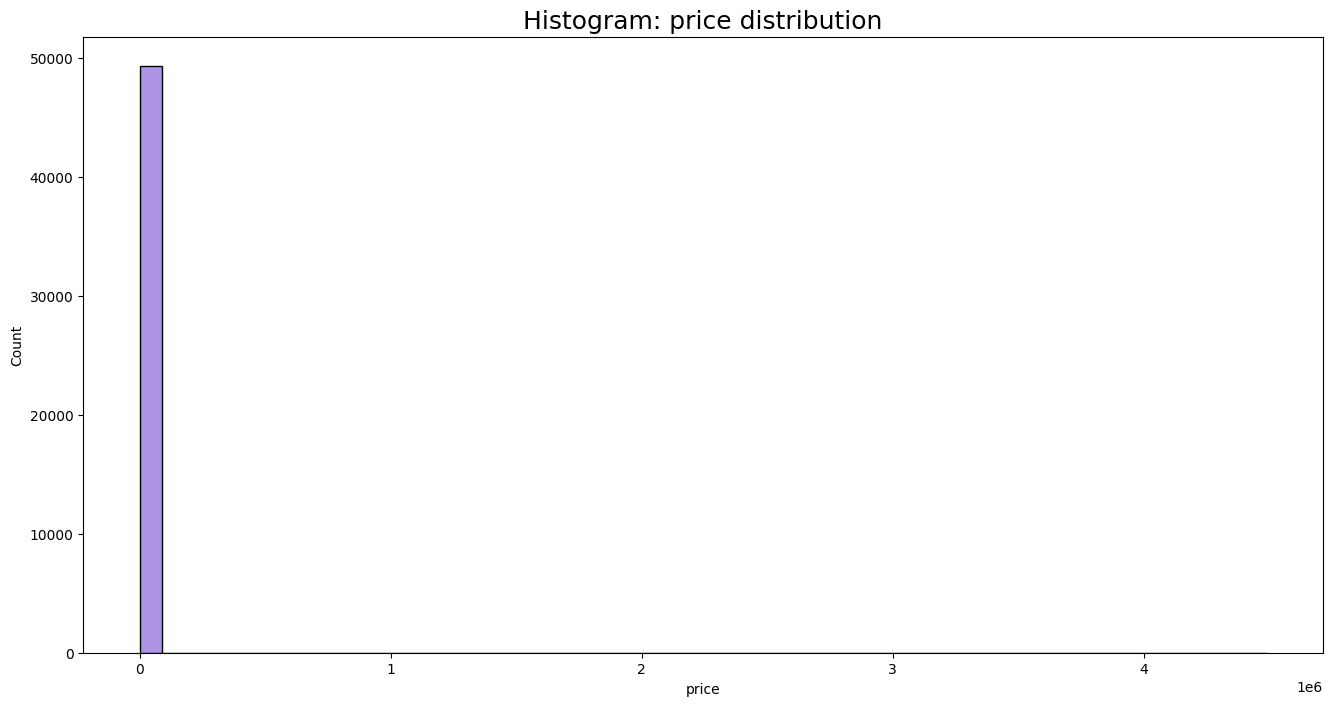

In [8]:
plt.figure(figsize=(16,8))
sns.histplot(data=df['price'], bins=50, color='mediumpurple')
plt.title('Histogram: price distribution', fontsize=18)
plt.show()

У `price` большой разброс значений, поэтому на линейной шкале распределение нечитабельно.

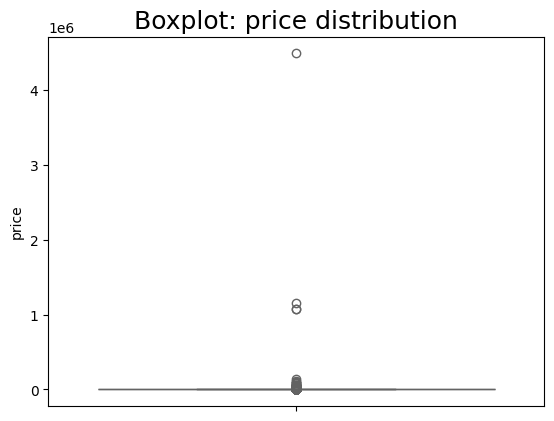

In [9]:
sns.boxplot(data=df['price'], color='mediumpurple')
plt.title('Boxplot: price distribution', fontsize=18)
plt.show()

По boxplot видно, что у нас очень много выбросов - точек за усами.

Удалим строки, выходящие за 1 и 99 перцентиль.

In [10]:
percentile_99 = np.percentile(df['price'], 99)
percentile_1 = np.percentile(df['price'], 1)
df = df[(percentile_1 < df['price']) & (df['price'] < percentile_99)]

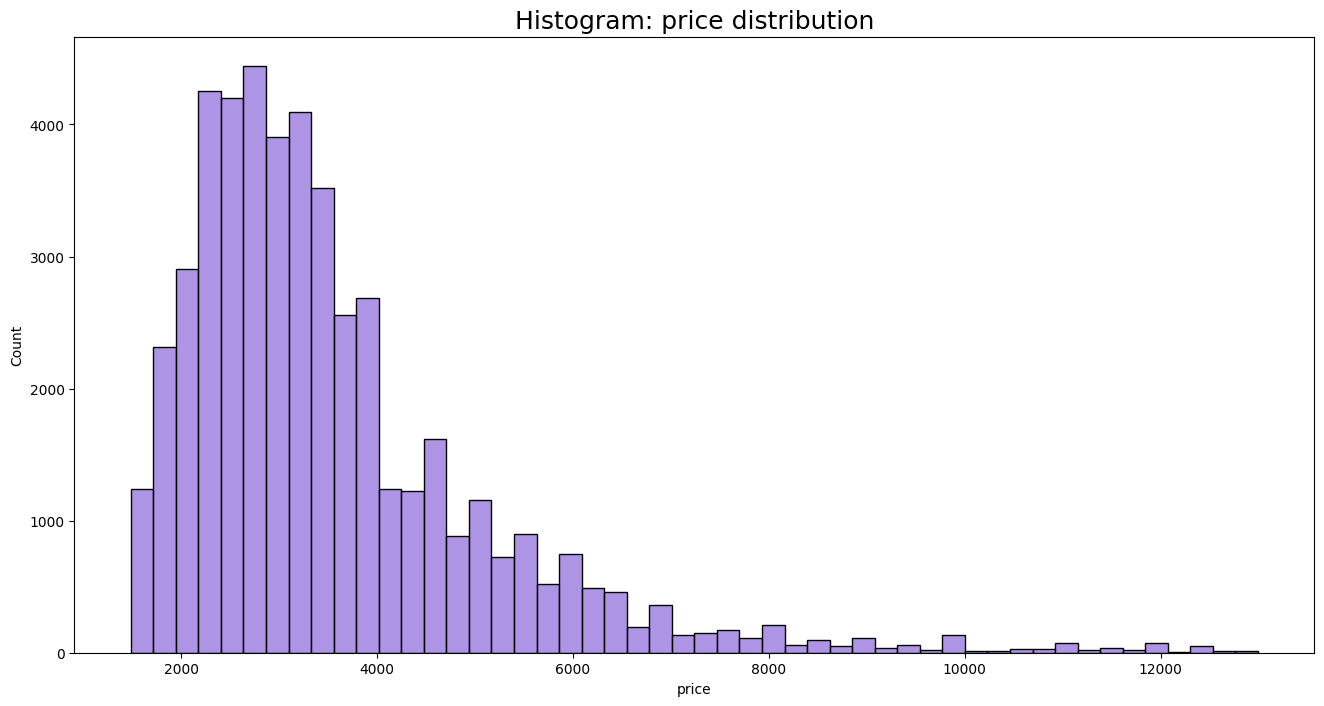

In [11]:
plt.figure(figsize=(16,8))
sns.histplot(data=df['price'], bins=50, color='mediumpurple')
plt.title('Histogram: price distribution', fontsize=18)
plt.show()

После удаления выбросов график стал читаемый на линейной шкале. Крайние значения не искажают визуальное восприятие распределения. Теперь можем более точно определить, что большинство значений сосредоточено в диапазоне от 2000 до 4000.

### 2. Characteristics Analysis

`'interest_level'` - уровень интереса к квартире.

In [12]:
df['interest_level'].dtype

dtype('O')

То есть тип данных `object`.

In [13]:
df['interest_level']

4         medium
6            low
9         medium
10        medium
15           low
           ...  
124000       low
124002    medium
124004    medium
124008    medium
124009      high
Name: interest_level, Length: 48343, dtype: object

In [14]:
Counter(df['interest_level'])

Counter({'low': 33672, 'medium': 11114, 'high': 3557})

Закодируем эти значения. Заменим каждое на 0, 1 и 2.

In [15]:
le = LabelEncoder()
le.fit(df['interest_level'])
le.classes_

array(['high', 'low', 'medium'], dtype=object)

In [16]:
df['interest_level'] = le.transform(df['interest_level'])
df.head()

,bathrooms,bedrooms,interest_level,price
4,1.0,1,2,2400
6,1.0,2,1,3800
9,1.0,2,2,3495
10,1.5,3,2,3000
15,1.0,0,1,2795


Таким образом, `'high'` -> 0, `'low'` -> 1, `'medium'` -> 2.

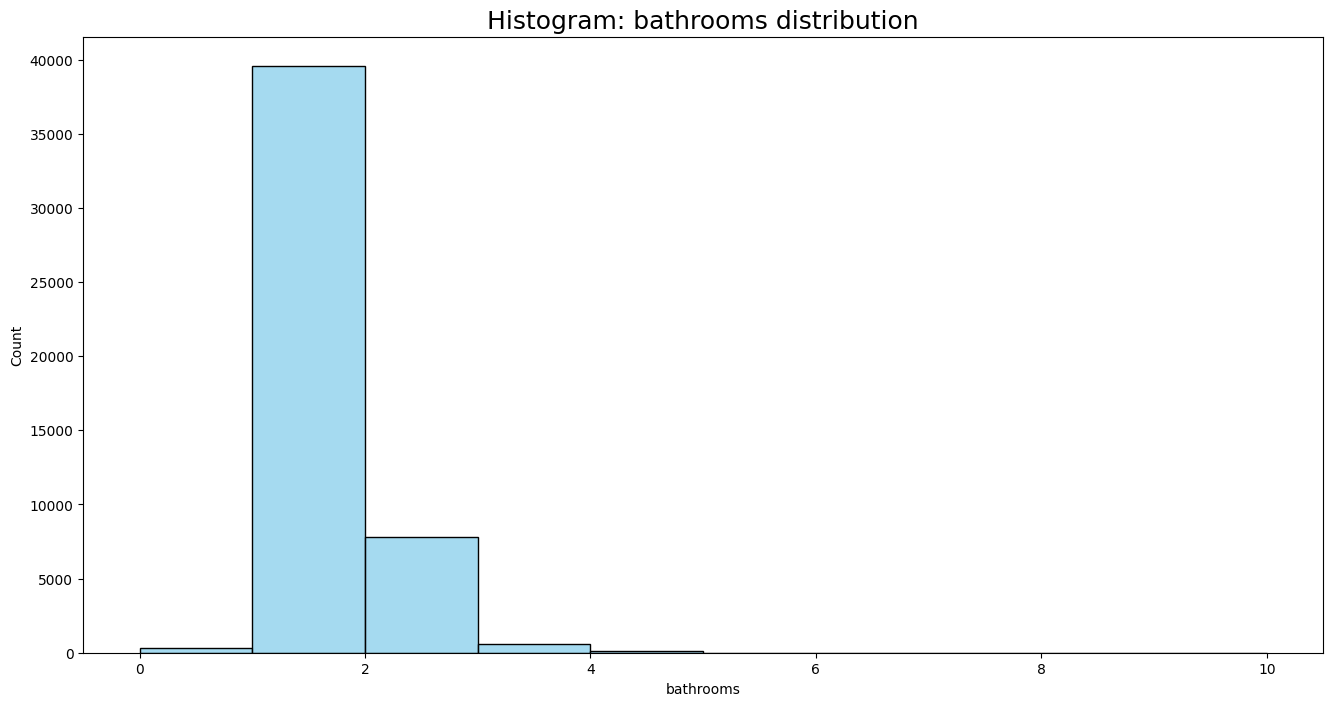

In [17]:
plt.figure(figsize=(16,8))
sns.histplot(data=df['bathrooms'], bins=10, color='skyblue')
plt.title('Histogram: bathrooms distribution', fontsize=18)
plt.show()

Из графика видно, что большинство квартир имеет 1-2 ванных комнаты. Единичные квартиры с 5-10 ванными не являются выбросами, так как их значения находятся в реальном диапазоне.

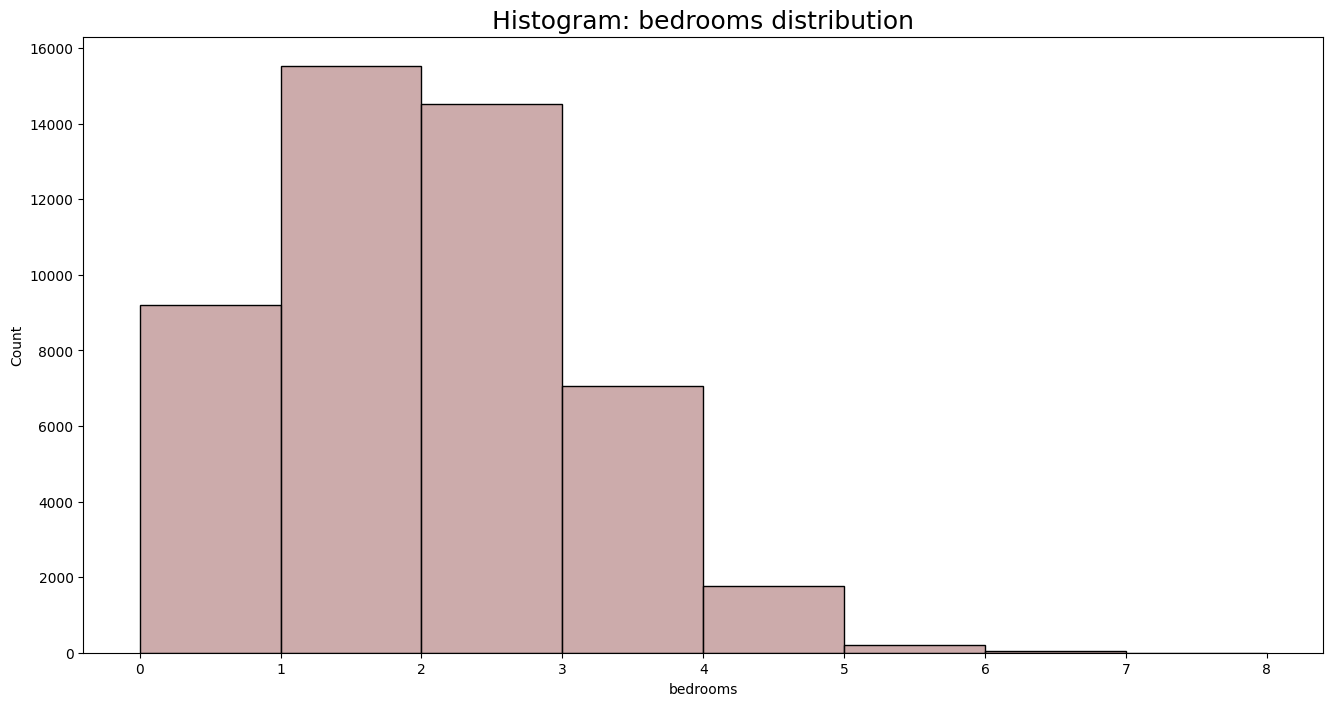

In [18]:
plt.figure(figsize=(16,8))
sns.histplot(data=df['bedrooms'], bins=8, color='rosybrown')
plt.title('Histogram: bedrooms distribution', fontsize=18)
plt.show()

Большинство квартир имеет 0-3 спальни. Единичные квартиры с 7-8 спальнями также не являются выбросами из-за небольшого разброса данных.

### 3. Complex analysis

In [19]:
corr_matrix = df.corr()
corr_matrix

,bathrooms,bedrooms,interest_level,price
bathrooms,1.000000,0.517200,-0.006359,0.670808
bedrooms,0.517200,1.000000,0.028767,0.547310
interest_level,-0.006359,0.028767,1.000000,-0.033230
price,0.670808,0.547310,-0.033230,1.000000


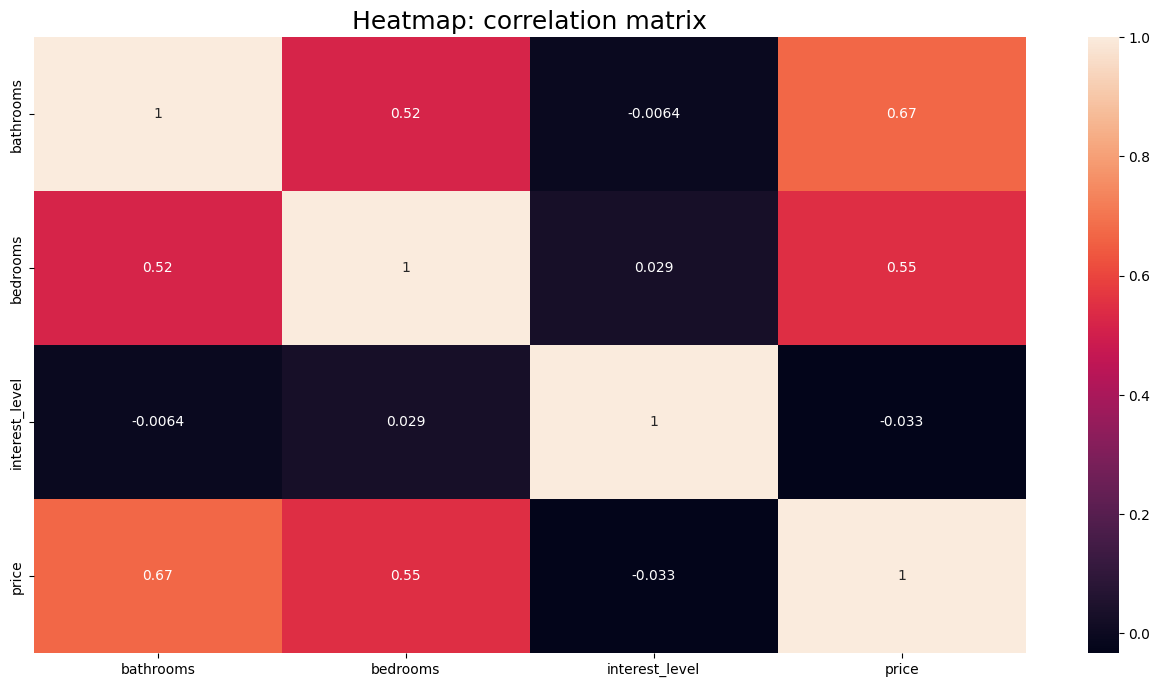

In [20]:
plt.figure(figsize=(16,8))
sns.heatmap(data=corr_matrix, annot=True)
plt.title('Heatmap: correlation matrix', fontsize=18)
plt.show()

У target наблюдается большая корреляция с признаками `bathrooms` (0,67) и `bedrooms` (0,55).  
Между самими features связь достаточно низкая, за исключением пары `bathrooms` и `bedrooms`. Между ними наблюдается наибольшая корреляция - 0,52.

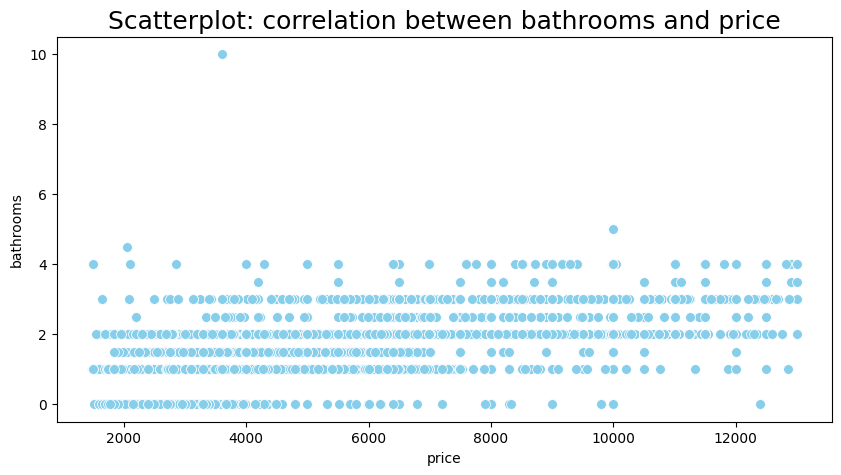

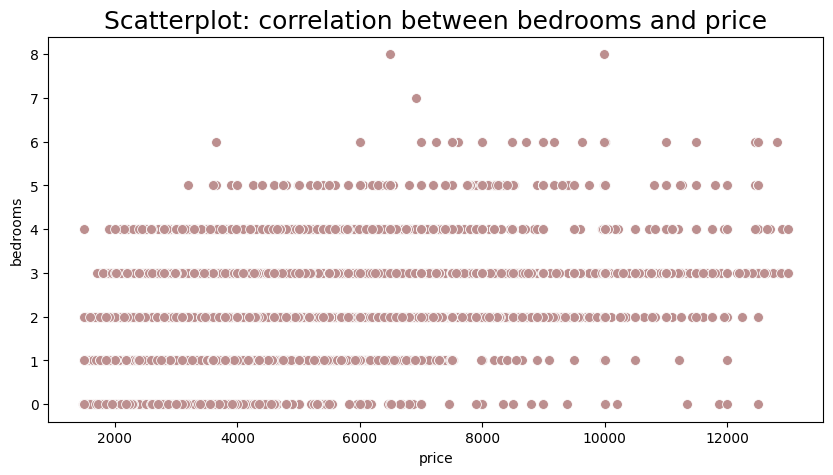

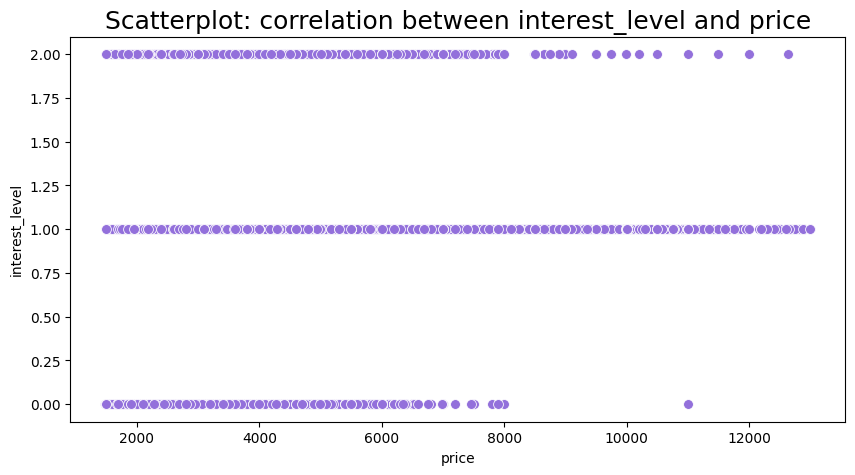

In [21]:
colormap = {'bathrooms': 'skyblue', 'bedrooms': 'rosybrown', 'interest_level': 'mediumpurple'}
for feature in colormap:
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=df, x='price', y=feature, s=50, color=colormap[feature])
    plt.title(f'Scatterplot: correlation between {feature} and price', fontsize=18)
    plt.show()

Scatterplot для `bathrooms` и `price` показывает, что с увеличением цены в среднем растёт количество ванных комнат.  
Схожая зависимость и на графике `bedrooms` и `price`, однако при ценах >7000 значительно меньше квартир как с 0-1 спальней, так и с >4.  
На графике корреляции между `interest_level` и `price` видно, что после 8000 практически отсутствуют квартиры 0 уровня интереса (high) и уменьшаются со 2 уровенем (medium).

## 3. Creating Features

In [22]:
df['bathrooms_squared'] = df['bathrooms'] ** 2
df['bedrooms_squared'] = df['bedrooms'] ** 2
df['interest_level_squared'] = df['interest_level'] ** 2

In [23]:
df.corr()

,bathrooms,bedrooms,interest_level,price,bathrooms_squared,bedrooms_squared,interest_level_squared
bathrooms,1.000000,0.517200,-0.006359,0.670808,0.955906,0.548426,-0.025398
bedrooms,0.517200,1.000000,0.028767,0.547310,0.478497,0.928282,0.042618
interest_level,-0.006359,0.028767,1.000000,-0.033230,-0.012183,0.027616,0.950897
price,0.670808,0.547310,-0.033230,1.000000,0.646949,0.544612,-0.092806
bathrooms_squared,0.955906,0.478497,-0.012183,0.646949,1.000000,0.521951,-0.032337
bedrooms_squared,0.548426,0.928282,0.027616,0.544612,0.521951,1.000000,0.040236
interest_level_squared,-0.025398,0.042618,0.950897,-0.092806,-0.032337,0.040236,1.000000


- Для `bathrooms` и `bedrooms` возведение в квадрат слегка уменьшило линейную зависимость с `target`:
    - bathrooms: 0.67 -> 0.65
    - bedrooms: 0.55 -> 0.54
- Для `interest_level` по модулю связь немного выросла, но всё равно осталась слабой:
    - interest_level: -0.033 -> -0.093

Are the new features more correlated with the target than the basic features? - `No`

In [24]:
X_train = df[['bathrooms', 'bedrooms']]
y_train = df['price']

In [25]:
test = pd.read_json('./data/test.json')
test = test[['bathrooms', 'bedrooms', 'price']]
test.describe()

,bathrooms,bedrooms,price
count,74659.000000,74659.000000,7.465900e+04
mean,1.212915,1.544663,3.749033e+03
std,0.649820,1.107014,9.713092e+03
min,0.000000,0.000000,1.000000e+00
25%,1.000000,1.000000,2.495000e+03
50%,1.000000,1.000000,3.150000e+03
75%,1.000000,2.000000,4.100000e+03
max,112.000000,7.000000,1.675000e+06


По таблице можно сказать, что есть выбросы:
- Максимальное значение bathrooms - 112, что выходит из диапазона допустимых значений.
- Price сильно разбросан: от 1 до 1675000  
  
Вывод: необходимо почистить test.

In [26]:
percentile_99 = np.percentile(test['price'], 99)
percentile_1 = np.percentile(test['price'], 1)
test = test[(percentile_1 < test['price']) & (test['price'] < percentile_99) & (test['bathrooms'] <= 10)]
test.describe()

,bathrooms,bedrooms,price
count,73127.000000,73127.000000,73127.000000
mean,1.193499,1.536341,3527.621521
std,0.450478,1.090992,1573.245577
min,0.000000,0.000000,1496.000000
25%,1.000000,1.000000,2500.000000
50%,1.000000,1.000000,3150.000000
75%,1.000000,2.000000,4075.000000
max,6.500000,7.000000,12995.000000


In [27]:
X_test = test[['bathrooms', 'bedrooms']]
y_test = test['price']

In [28]:
poly = PolynomialFeatures(10)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

## 4. Train models

In [29]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = result_MAE.copy()

### 1. Linear Regression

In [30]:
reg = LinearRegression()
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

In [31]:
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
result_MAE.loc[0] = ['linear_regression', mae_train, mae_test]

In [32]:
rmse_train = root_mean_squared_error(y_train, pred_train)
rmse_test = root_mean_squared_error(y_test, pred_test)
result_RMSE.loc[0] = ['linear_regression', rmse_train, rmse_test]

### 2. Decision Tree

In [33]:
reg = DecisionTreeRegressor(random_state=21)
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

In [34]:
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
result_MAE.loc[1] = ['decision_tree', mae_train, mae_test]

In [35]:
rmse_train = root_mean_squared_error(y_train, pred_train)
rmse_test = root_mean_squared_error(y_test, pred_test)
result_RMSE.loc[1] = ['decision_tree', rmse_train, rmse_test]

### 3. Naive Models

#### 1. Naive mean

In [36]:
pred_train = [np.mean(y_train)] * len(y_train)
pred_test = [np.mean(y_test)] * len(y_test)

In [37]:
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
result_MAE.loc[2] = ['naive_mean', mae_train, mae_test]

In [38]:
rmse_train = root_mean_squared_error(y_train, pred_train)
rmse_test = root_mean_squared_error(y_test, pred_test)
result_RMSE.loc[2] = ['naive_mean', rmse_train, rmse_test]

#### 2. Naive median

In [39]:
pred_train = [np.median(y_train)] * len(y_train)
pred_test = [np.median(y_test)] * len(y_test)

In [40]:
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
result_MAE.loc[3] = ['naive_median', mae_train, mae_test]

In [41]:
rmse_train = root_mean_squared_error(y_train, pred_train)
rmse_test = root_mean_squared_error(y_test, pred_test)
result_RMSE.loc[3] = ['naive_median', rmse_train, rmse_test]

### 4. Results

In [42]:
result_MAE

,model,train,test
0,linear_regression,753.679393,2047.355365
1,decision_tree,753.675997,756.432418
2,naive_mean,1134.361473,1128.889105
3,naive_median,1082.220859,1078.660235


In [43]:
result_RMSE

,model,train,test
0,linear_regression,1070.669027,212040.197047
1,decision_tree,1070.598967,1073.411607
2,naive_mean,1585.609099,1573.234820
3,naive_median,1631.719953,1617.920212
